In [2]:
import os
import pydicom
import cv2
import skimage.feature
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
####Get images meta data####
meta_data = pd.read_excel('/Users/emanismail/Documents/Diploma/Machine Learning /project/clinical_data.xlsx')
#### Droping the unnecessary columns####
columns_to_be_dropped = ['LeftRight','number','classification','abnormality']
meta_data = meta_data.drop(columns=columns_to_be_dropped)

In [4]:
#### Function that loops over the Folder of the dicom images and get the images ####
def read_dicom_files(root_folder):
    dicom_files = []
    patient_ids_list =[]
    file_paths =[]
    images_labels =[]
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                dicom_file = pydicom.dcmread(file_path)
                dicom_files.append(dicom_file)
                file_paths.append(file_path)
                patient_ids_list.append(dicom_file.PatientID)
            except Exception as e:
                pass
                #print(f"Error reading file {file_path}: {e}")pip show opencv-python
    
    return dicom_files, patient_ids_list,file_paths
root_folder_path = '/Users/emanismail/Documents/Diploma/Machine Learning /project/Data/manifest-1704997911617'
dicom_images,patients_image_id,_=read_dicom_files(root_folder_path)
print(len(patients_image_id))

1992


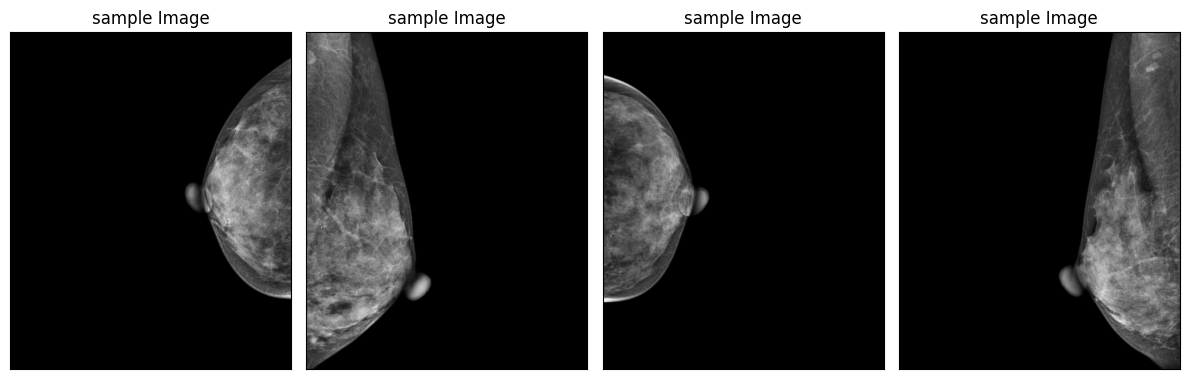

In [53]:
#### Function that shows some of the images ####

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
for i in range(4):
       # Get pixel data from the DICOM file
       pixel_data = dicom_images[i].pixel_array
       # Display the DICOM image on the current subplot
       axs[i].imshow(pixel_data, cmap='gray')

       # Set title (optional)
       axs[i].set_title(f"sample Image")

       # Remove axis ticks and labels (optional)
       axs[i].set_xticks([])
       axs[i].set_yticks([])
       axs[i].set_xticklabels([])
       axs[i].set_yticklabels([])
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

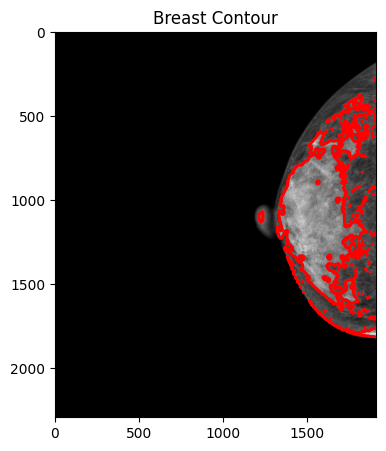

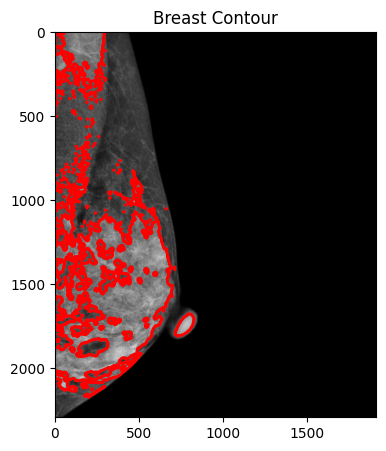

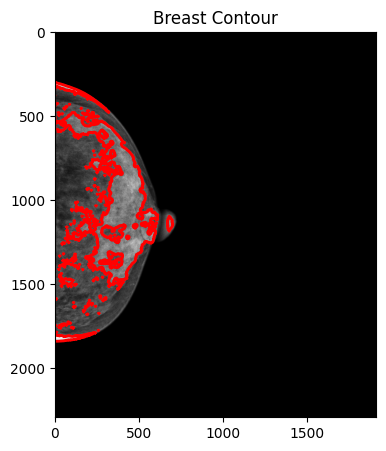

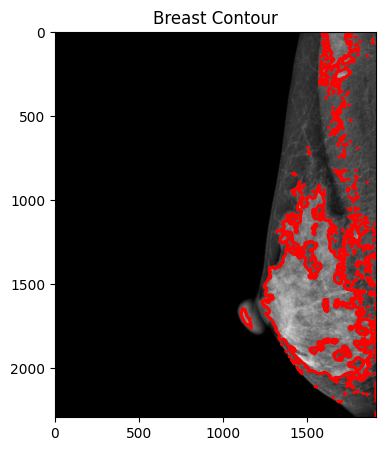

In [56]:
#### Function that shows some of the images conroured around the breast####

from skimage import measure
from skimage import measure, morphology

def breast_outer_contour(image, threshold=0.5):
    # Threshold the image to separate the breast region
    binary_mask = image > threshold
    
    # Perform morphological closing to close small gaps in the binary mask
    closed_mask = morphology.closing(binary_mask, morphology.disk(8))

    # Find contours in the closed binary mask
    contours = measure.find_contours(closed_mask, 0.5)

    # Display the original DICOM image
    plt.imshow(image, cmap='gray')

    # Plot the outer contour on the original image
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
     
   

for i in range(4):
        # Get pixel data from the DICOM file
            pixel_data = dicom_images[i].pixel_array
            # Normalize pixel values to the range [0, 1]
            # Normalize pixel values to the range [0, 1]
            normalized_pixel_data = (pixel_data - np.min(pixel_data)) / (np.max(pixel_data) - np.min(pixel_data))
            plt.figure(figsize=(10, 5))
            # Display the original DICOM image with breast contour
            breast_outer_contour(normalized_pixel_data)
            plt.subplot()

            plt.title('Breast Contour')
        
            plt.show()

In [65]:
#### Function that extract the boundaries, and crop the images  ####

import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.transform import resize

def extract_bounding_box(image,dicom_images, threshold=0.5):
    # Threshold the image to separate the breast region
    binary_mask = image > threshold
    #--> the size is the number of non-zero pixels, any pixel with mass
    tumor_size = np.sum(binary_mask > 0)
    # Perform morphological closing to close small gaps in the binary mask
    closed_mask = morphology.closing(binary_mask, morphology.disk(8))
    patient_id_list = dicom_images.PatientID
    # Find contours in the closed binary mask
    contours = measure.find_contours(closed_mask, 0.5)

    # Find the largest contour (assumed to be the breast contour)
    largest_contour = max(contours, key=len)

    # Get the bounding box of the contour
    min_row, max_row, min_col, max_col = (
        int(np.min(largest_contour[:, 0])),
        int(np.max(largest_contour[:, 0])),
        int(np.min(largest_contour[:, 1])),
        int(np.max(largest_contour[:, 1])),
    )

    # Extract the rectangle around the contoured part of the image
    cropped_image = image[min_row:max_row, min_col:max_col]

    return cropped_image, tumor_size,patient_id_list

# Directory containing DICOM files
#dicom_folder = '/path/to/your/dicom/folder'
dicom_images,_,_= read_dicom_files(root_folder_path)

# List to store cropped images
cropped_images = []
sizes =[]
patient_id_list=[]
# Initialize variables for maximum size
max_height = 0
max_width = 0

# Iterate through all DICOM files in the folder
# for filename in os.listdir(dicom_folder):
#     if filename.endswith('.dcm'):
for i in range(500):
        #file_path = os.path.join(dicom_folder, filename)

        # Read the DICOM file
        #dicom_file = pydicom.dcmread(file_path)

        # Get pixel data from the DICOM file
        pixel_data = dicom_images[i].pixel_array

        # Normalize pixel values to the range [0, 1]
        normalized_pixel_data = (pixel_data - np.min(pixel_data)) / (np.max(pixel_data) - np.min(pixel_data))

        # Extract the rectangle around the contoured part of the image
        cropped_image,size,patient_id  = extract_bounding_box(normalized_pixel_data,dicom_images[i])
        
        # Update maximum size
        max_height = max(max_height, cropped_image.shape[0])
        max_width = max(max_width, cropped_image.shape[1])

        # Append the cropped image to the list
        cropped_images.append(cropped_image)
        sizes.append(size)
        patient_id_list.append(patient_id)


# Get the shapes of each array in the list
shapes = [arr.shape for arr in cropped_images]

# Print or use the list of shapes
"""
for shape in shapes:
    print(shape)
"""
# Resize all cropped images to the maximum size
resized_images = [resize(img, (max_height, max_width), mode='reflect', anti_aliasing=True) for img in cropped_images]
shapes = [arr.shape for arr in resized_images]
print(len(resized_images))
# # Print or use the list of shapes
# for shape in shapes:
#     print("resized images size is ",shape)
 


500


(1043, 529)
(1094, 700)
(1032, 568)
(1165, 672)
resized images size is  (1165, 700)
resized images size is  (1165, 700)
resized images size is  (1165, 700)
resized images size is  (1165, 700)


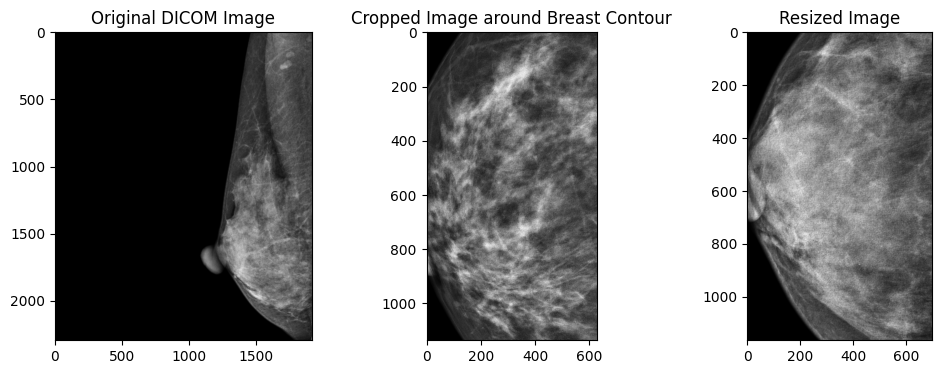

In [66]:
#### Function that extract the boundaries, and crop the images using only 4 samples for visulization  ####
cropped_images_visualization =[]
max_height = 0
max_width = 0
for i in range(4):
        #file_path = os.path.join(dicom_folder, filename)

        # Read the DICOM file
        #dicom_file = pydicom.dcmread(file_path)

        # Get pixel data from the DICOM file
        pixel_data = dicom_images[i].pixel_array

        # Normalize pixel values to the range [0, 1]
        normalized_pixel_data = (pixel_data - np.min(pixel_data)) / (np.max(pixel_data) - np.min(pixel_data))

        # Extract the rectangle around the contoured part of the image
        cropped_image_v,_,_ = extract_bounding_box(normalized_pixel_data,dicom_images[i])
       
        # Update maximum size
        max_height = max(max_height, cropped_image_v.shape[0])
        max_width = max(max_width, cropped_image_v.shape[1])
    
        # Append the cropped image to the list
        cropped_images_visualization.append(cropped_image_v)

# Get the shapes of each array in the list
shapes = [arr.shape for arr in cropped_images_visualization]

# Print or use the list of shapes
for shape in shapes:
    print(shape)

# Resize all cropped images to the maximum size
resized_images = [resize(img, (max_height, max_width), mode='reflect', anti_aliasing=True) for img in cropped_images_visualization]

shapes_v = [arr.shape for arr in resized_images]

# Print or use the list of shapes
for shape in shapes_v:
    print("resized images size is ",shape)
 
# Display the original DICOM image and the resized images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(normalized_pixel_data, cmap='gray')
plt.title('Original DICOM Image')

plt.subplot(1, 3, 2)
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image around Breast Contour')

plt.subplot(1, 3, 3)
plt.imshow(resized_images[0], cmap='gray')
plt.title('Resized Image')

plt.show()


In [43]:
import numpy as np
import mahotas.features
###Use the cropped images as an input to extract the features###
dicom_images,patient_ids_list_full,_= read_dicom_files(root_folder_path)
features_df = pd.DataFrame()
print(len(dicom_images))

for i in range(500):
    
    image_array = dicom_images[i].pixel_array.astype(np.uint8)
    ########image_id = patient_id_list[i]
    
    image_id = patient_ids_list_full[i]
    
    ###tumor_size = sizes[i]
    # Create a binary mask (for simplicity, use a binary mask covering the entire image)
    #mask_array = np.ones_like(resized_images[i], dtype=np.uint8)

    # Convert the image to grayscale if needed
    gray_image = np.squeeze(image_array)
    
    #####img_int = (resized_images[i] * 255).astype(np.uint8)
    
    """"The input is the resized images in case of cropped images(img_int) and image_array(dicom images) in case of original images"""
    # Calculate GLCM features
    #############################################################################
    glcm_features = mahotas.features.haralick(gray_image, ignore_zeros=True)
    flattened_features = np.ravel(glcm_features).reshape((1,-1))
    df = pd.DataFrame(flattened_features)
    df['patients_id']=image_id
    ######df['size']=tumor_size
    features_df = pd.concat([df,features_df],axis=0, ignore_index=True)

    # # Print the GLCM features
    # print("GLCM Features:")
    # for i, feature in enumerate(glcm_features):
    #     print(f"Feature {i + 1}: {feature}")

    # Convert NumPy array to DataFrame
print(features_df.shape)


    # Display the DataFrame
    

1992
(500, 53)


In [44]:
######Features######
result_df = pd.merge(features_df, meta_data, on='patients_id', how='left')
result_df_used_in_analysis = pd.merge(features_df, meta_data, on='patients_id', how='left')
print(result_df.shape)

(500, 57)


In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import accuracy_score


# Create a new DataFrame with a column named 'subtype'
y = pd.DataFrame({'subtype': result_df['subtype']})
#print(y.columns)
label_encoder = LabelEncoder()
y['subtype'] = label_encoder.fit_transform(y['subtype'])
#y = pd.get_dummies(y, columns=['subtype'])
#print(y.head(2))
####################################################

x=result_df.drop(columns=['subtype','patients_id'])

label_encoder = LabelEncoder()
x['calcifications'] = label_encoder.fit_transform(x['calcifications'])
x['margin'] = label_encoder.fit_transform(x['margin'])

#x=result_df.drop(columns=['Age','calcifications','margin','subtype','patients_id'])

#Convert Column name type to string to avoid confusion in applying the algorithms
x.columns = x.columns.astype(str)
#x__ = result_df[['Age','calcifications']]
#x__['calcifications'] = label_encoder.fit_transform(x__['calcifications'])
print(x.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', 'Age', 'calcifications', 'margin'],
      dtype='object')


In [75]:
print(y.shape)
print(x.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

(500, 1)
(500, 55)


In [76]:
logr = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')
logr.fit(x_train, y_train)
pred = logr.predict(x_test)
print(accuracy_score(y_test, pred))

0.55


/Users/emanismail/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/emanismail/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
from sklearn.metrics import mean_squared_error, r2_score
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(x_train, y_train)
pred = forest_model.predict(x_test)
# Evaluate the model
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

/Users/emanismail/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 0.11
R-squared (R2): 0.89


## Features Analysis

/var/folders/31/dkv6wp2d45v2jcl4t2m1y4jr0000gn/T/ipykernel_5042/1165301432.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  R_cmap = get_cmap('RdPu')


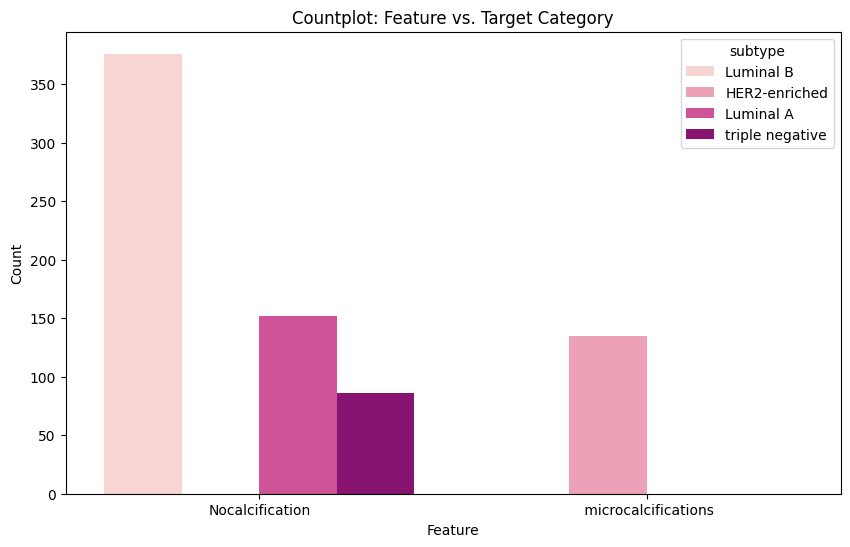

/var/folders/31/dkv6wp2d45v2jcl4t2m1y4jr0000gn/T/ipykernel_5042/1165301432.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='calcifications', y='subtype', data=meta_data,palette='RdPu')
/Users/emanismail/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3398: UserWarning: 62.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/emanismail/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3398: UserWarning: 43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/emanismail/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3398: UserWarning: 79.0% of the points cannot be placed; you may want to decrease th

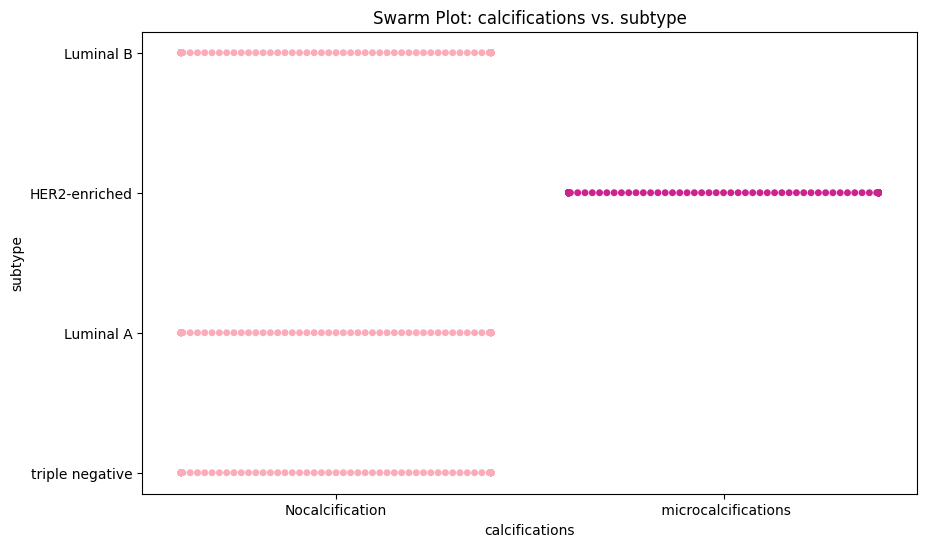

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
# Choose the colormap
R_cmap = get_cmap('RdPu')

# Create a custom colormap starting from a darker shade
dark_R_cmap = ListedColormap(R_cmap(np.linspace(0.3, 1, 256)))

# Countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='calcifications', hue='subtype', data=meta_data,palette='RdPu')
plt.title('Countplot: Feature vs. Target Category')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.swarmplot(x='calcifications', y='subtype', data=meta_data,palette='RdPu')
plt.title('Swarm Plot: calcifications vs. subtype')
plt.xlabel('calcifications')
plt.ylabel('subtype')
plt.show()

/var/folders/31/dkv6wp2d45v2jcl4t2m1y4jr0000gn/T/ipykernel_5042/22412342.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='subtype', y='size', data=result_df_used_in_analysis,palette='RdPu')


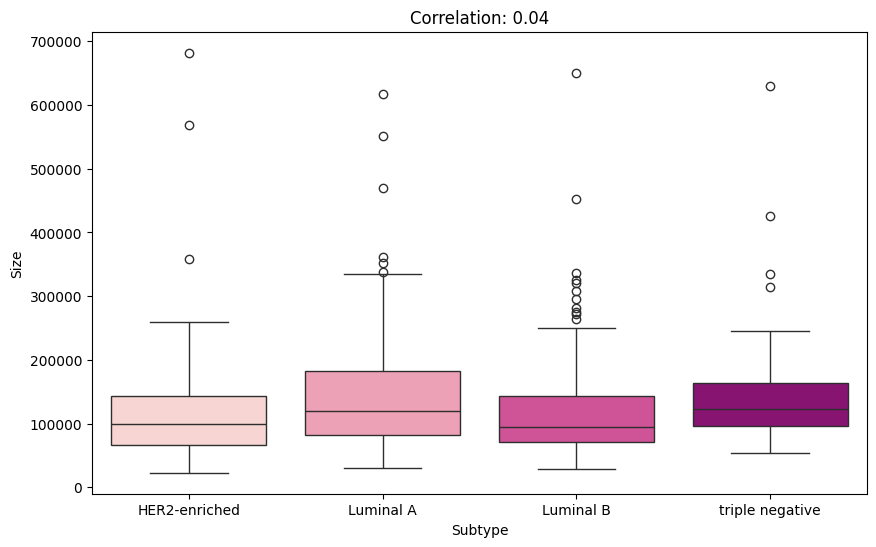

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

# Example dataset
np.random.seed(42)
data = {'Size': np.random.randint(1, 100, size=1000),
        'Target': np.random.choice(['Category1', 'Category2'], size=1000)}

df = pd.DataFrame(data)

# Calculate point-biserial correlation
corr_coefficient, _ = pointbiserialr(result_df_used_in_analysis['size'], result_df_used_in_analysis['subtype'].astype('category').cat.codes)

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='subtype', y='size', data=result_df_used_in_analysis,palette='RdPu')
plt.title(f'Correlation: {corr_coefficient:.2f}')
plt.xlabel('Subtype')
plt.ylabel('Size')
plt.show()



/var/folders/31/dkv6wp2d45v2jcl4t2m1y4jr0000gn/T/ipykernel_5042/679427340.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='size', y='subtype', data=result_df_used_in_analysis,palette='RdPu')
/Users/emanismail/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3398: UserWarning: 9.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


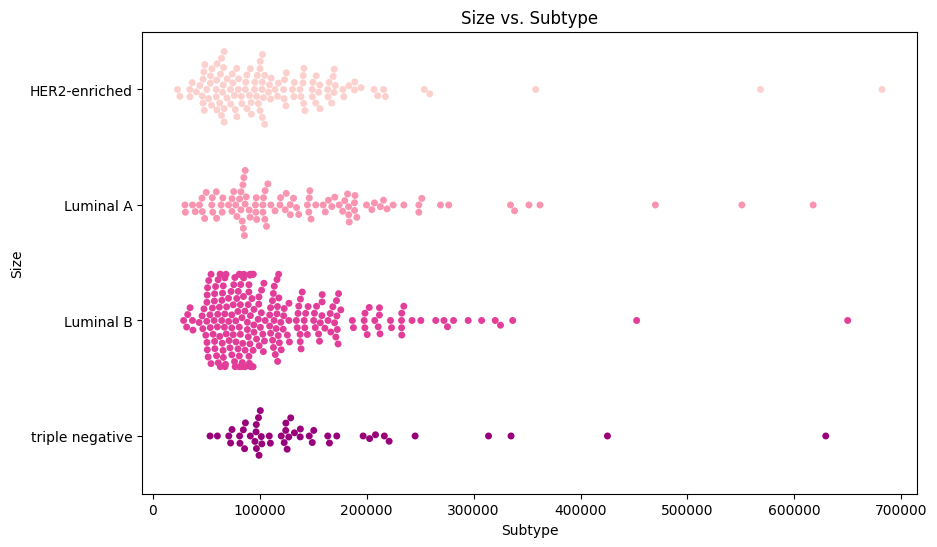

In [33]:
# Swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='size', y='subtype', data=result_df_used_in_analysis,palette='RdPu')
plt.title('Size vs. Subtype')
plt.xlabel('Subtype')
plt.ylabel('Size')
plt.show()


/var/folders/31/dkv6wp2d45v2jcl4t2m1y4jr0000gn/T/ipykernel_6831/1385621364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='subtype', data=meta_data, palette='RdPu')


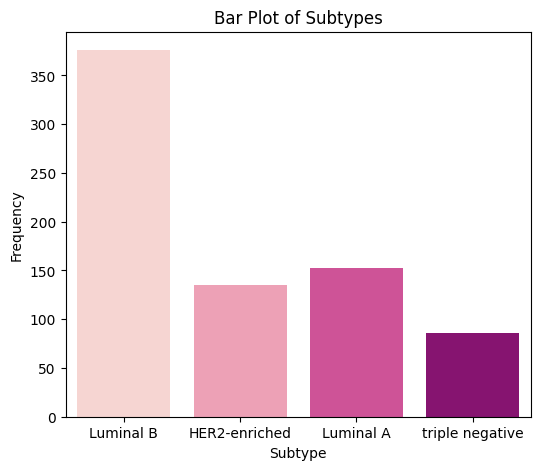

In [69]:
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.countplot(x='subtype', data=meta_data, palette='RdPu')
plt.xlabel('Subtype')
plt.ylabel('Frequency')
plt.title('Bar Plot of Subtypes')
plt.show()

/var/folders/31/dkv6wp2d45v2jcl4t2m1y4jr0000gn/T/ipykernel_6831/2559071341.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = meta_data.groupby(['AgeGroup', 'subtype']).size().unstack(fill_value=0)


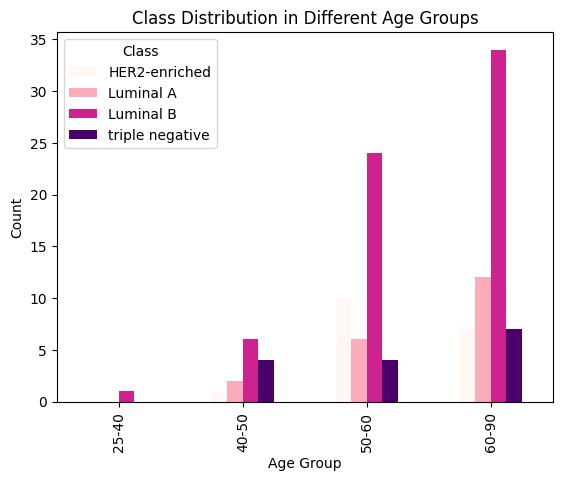

In [72]:
# define age groups
age_bins = [20, 25, 30, 35, 40]
age_labels = ['25-40', '40-50', '50-60', '60-90']

# create 'AgeGroup' column in DataFrame
meta_data['AgeGroup'] = pd.cut(meta_data['Age'], bins=age_bins, labels=age_labels, right=False)

# count occurrences of classes within each age group
grouped_counts = meta_data.groupby(['AgeGroup', 'subtype']).size().unstack(fill_value=0)

# plot a grouped bar chart
grouped_counts.plot(kind='bar', colormap='RdPu')
plt.title('Class Distribution in Different Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Class')
plt.show()

/var/folders/31/dkv6wp2d45v2jcl4t2m1y4jr0000gn/T/ipykernel_6831/3404687404.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(m.keys()), y=list(m.values()), palette='RdPu')


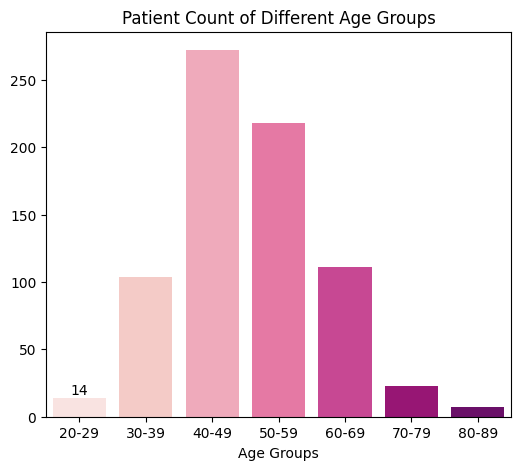

In [74]:
# age distribution
m = {
    '20-29' : 0,
    '30-39' : 0,
    '40-49' : 0,
    '50-59' : 0,
    '60-69' : 0,
    '70-79' : 0,
    '80-89' : 0
}
for index, row in meta_data.iterrows():
    if row['Age']>=20 and row['Age']<30: m['20-29'] += 1
    elif row['Age']>=30 and row['Age']<40: m['30-39'] += 1
    elif row['Age']>=40 and row['Age']<50: m['40-49'] += 1
    elif row['Age']>=50 and row['Age']<60: m['50-59'] += 1
    elif row['Age']>=60 and row['Age']<70: m['60-69'] += 1
    elif row['Age']>=70 and row['Age']<80: m['70-79'] += 1
    else: m['80-89'] += 1
fig, ax = plt.subplots(figsize=(6,5))
ax = sns.barplot(x=list(m.keys()), y=list(m.values()), palette='RdPu')
ax.bar_label(ax.containers[0])
plt.title("Patient Count of Different Age Groups")
plt.xlabel("Age Groups")
plt.show()